Reference: https://github.com/thiagodma/Pytorch_exs/blob/master/MultiTaskLearning/multitask_age_gender_ethnicity_resnet34.ipynb

In [1]:
from fastai import *
from fastai.vision import *

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import torch

In [4]:
from fb_utils import set_device, get_dataloader, get_pytorch_model

In [5]:
from UTKFace_train_utils import get_df_files, get_image_databunch, get_gen_acc, get_df_of_concept

In [6]:
torch.cuda.set_device(0)
device, kwargs = set_device(device_name="cuda:0")
print(device, kwargs)
torch.cuda.empty_cache()

cuda:0 {'num_workers': 1, 'pin_memory': True}


## Creating multi_class dataframes for age

In [7]:
df_train, df_valid = get_df_files(concept='age', df_all_concepts=True, get_all_ages=True)

In [8]:
df_train.head()

,name,label,age,gender,ethnicity
0,UTKFace/58_0_3_20170119211544361.jpg.chip.jpg,58 0 3,58,0,1
1,UTKFace/38_0_0_20170116224644283.jpg.chip.jpg,38 0 0,38,0,0
2,UTKFace/18_1_0_20170109214216731.jpg.chip.jpg,18 1 0,18,1,0
3,UTKFace/32_1_3_20170109142352309.jpg.chip.jpg,32 1 3,32,1,1
4,UTKFace/26_1_0_20170117153211341.jpg.chip.jpg,26 1 0,26,1,0


In [9]:
df_valid.head()

,name,label,age,gender,ethnicity
0,crop_part1/18_1_0_20170109214216731.jpg.chip.jpg,18 1 0,18,1,0
1,crop_part1/32_1_3_20170109142352309.jpg.chip.jpg,32 1 3,32,1,1
2,crop_part1/36_0_1_20170105172620093.jpg.chip.jpg,36 0 1,36,0,1
3,crop_part1/1_0_3_20161220220606705.jpg.chip.jpg,1 0 3,1,0,1
4,crop_part1/32_1_0_20170103181503793.jpg.chip.jpg,32 1 0,32,1,0


In [10]:
df_train.loc[df_train["age"].idxmax()]

name         UTKFace/116_1_0_20170120134921760.jpg.chip.jpg
label                                               116 1 0
age                                                     116
gender                                                    1
ethnicity                                                 0
Name: 12898, dtype: object

In [11]:
df_train.loc[df_train["age"].idxmin()]

name         UTKFace/1_0_3_20161220220606705.jpg.chip.jpg
label                                               1 0 3
age                                                     1
gender                                                  0
ethnicity                                               1
Name: 10, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f071e69d790>]], dtype=object)

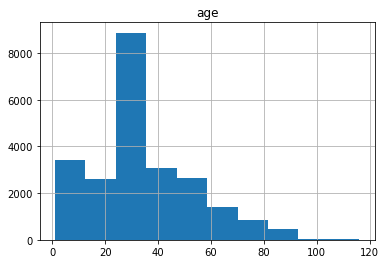

In [12]:
df_train.hist(column='age')

In [13]:
age_range = [0, 10, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
for i in range(1, len(age_range)):
    print(f"age range:{age_range[i-1]} to {age_range[i]}, freq:{df_train['age'].map(lambda x: age_range[i-1] < x <= age_range[i]).sum()}")
print()
print(f"age range:0 to 25, freq:{df_train['age'].map(lambda x: 0 < x <= 25).sum()}")
print(f"age range:25 to 36, freq:{df_train['age'].map(lambda x: 25 < x <= 36).sum()}")
print(f"age range:36 to 80, freq:{df_train['age'].map(lambda x: 36 < x <= 120).sum()}")

age range:0 to 10, freq:3218
age range:10 to 20, freq:1634
age range:20 to 25, freq:2711
age range:25 to 30, freq:4902
age range:30 to 35, freq:2406
age range:35 to 40, freq:1876
age range:40 to 50, freq:2045
age range:50 to 60, freq:2177
age range:60 to 70, freq:1172
age range:70 to 80, freq:685
age range:80 to 90, freq:453
age range:90 to 100, freq:66
age range:100 to 110, freq:13
age range:110 to 120, freq:8

age range:0 to 25, freq:7563
age range:25 to 36, freq:7786
age range:36 to 80, freq:8017


In [14]:
df_train.age = df_train.age.apply(lambda x: False if x <= 25 else x).astype(int)

In [15]:
df_train.age = df_train.age.apply(lambda x: True if 25 < x <= 36 else x).astype(int)

In [16]:
df_train.age = df_train.age.apply(lambda x: 2 if 36 < x <= 120 else x).astype(int)

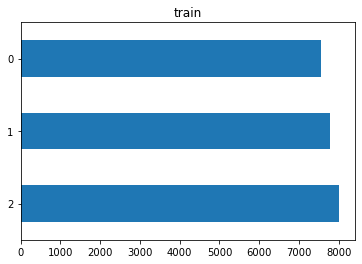

In [17]:
(df_train.age.value_counts()).plot.barh()
plt.title("train");

In [18]:
df_valid.age = df_valid.age.apply(lambda x: False if x <= 25 else x).astype(int)

In [19]:
df_valid.age = df_valid.age.apply(lambda x: True if 25 < x <= 36 else x).astype(int)

In [20]:
df_valid.age = df_valid.age.apply(lambda x: 2 if 36 < x <= 120 else x).astype(int)

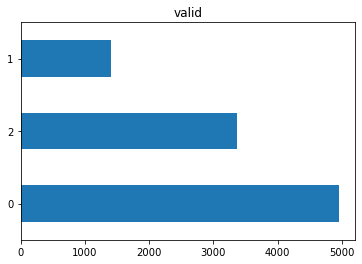

In [21]:
(df_valid.age.value_counts()).plot.barh()
plt.title("valid");

In [22]:
df_age = get_df_of_concept(df_train, df_valid, concept='age')

In [23]:
df_age

,image_id,age,is_valid
0,UTKFace/58_0_3_20170119211544361.jpg.chip.jpg,2,False
1,UTKFace/38_0_0_20170116224644283.jpg.chip.jpg,2,False
2,UTKFace/18_1_0_20170109214216731.jpg.chip.jpg,0,False
3,UTKFace/32_1_3_20170109142352309.jpg.chip.jpg,1,False
4,UTKFace/26_1_0_20170117153211341.jpg.chip.jpg,1,False
...,...,...,...
9717,crop_part1/2_1_2_20161219161934567.jpg.chip.jpg,0,True
9718,crop_part1/2_1_4_20161221192754807.jpg.chip.jpg,0,True
9719,crop_part1/1_0_2_20161219212824950.jpg.chip.jpg,0,True
9720,crop_part1/38_1_0_20170104200929513.jpg.chip.jpg,2,True


In [24]:
pickle.dump(df_age, open("df_age_multi.p", "wb"))

## Creating Dataset, dataloader and databunch: multi-class

In [25]:
data_age = get_image_databunch(df_age)

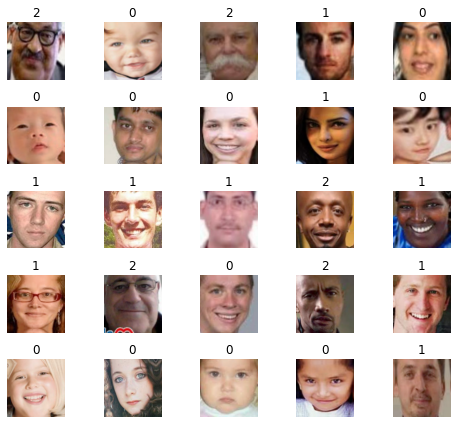

In [26]:
data_age.show_batch(rows=5, figsize=(7,6))

## Create Models: multi-class

In [27]:
learn_age_multi = cnn_learner(data_age, models.resnet50, metrics=accuracy, callback_fns=ShowGraph)
#learn_age_multi.freeze()

In [37]:
learn_age_multi

Learner(data=ImageDataBunch;

Train: LabelList (23366 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,2,0,1,1
Path: .;

Valid: LabelList (9722 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,1
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [38]:
learn_age_multi.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


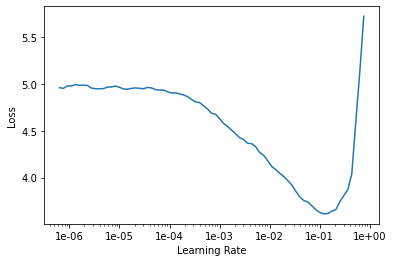

In [97]:
learn_age_multi.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.812801,0.453397,0.795104,01:44
1,0.659302,0.421559,0.806624,01:43
2,0.652285,0.379924,0.834499,01:43
3,0.640755,0.484653,0.788212,01:43
4,0.635586,0.389254,0.815367,01:43
5,0.594911,0.441150,0.801687,01:43
6,0.587045,0.382413,0.822156,01:43
7,0.571075,1.020404,0.771960,01:43
8,0.539686,0.301060,0.863197,01:43
9,0.529141,0.477111,0.868237,01:43


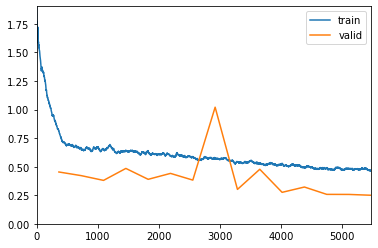

Better model found at epoch 0 with valid_loss value: 0.45339667797088623.
Better model found at epoch 1 with valid_loss value: 0.4215588867664337.
Better model found at epoch 2 with valid_loss value: 0.37992358207702637.
Better model found at epoch 8 with valid_loss value: 0.301059752702713.
Better model found at epoch 10 with valid_loss value: 0.27527064085006714.
Better model found at epoch 12 with valid_loss value: 0.2575470805168152.
Better model found at epoch 13 with valid_loss value: 0.2569887042045593.
Better model found at epoch 14 with valid_loss value: 0.2496863305568695.


In [39]:
learn_age_multi.fit_one_cycle(15, max_lr=1e-2, callbacks=[callbacks.SaveModelCallback(learn_age_multi, 
                                                                                  every='improvement', 
                                                                                  monitor='valid_loss', 
                                                                                  name='stage-1-age-multi')])

In [29]:
learn_age_multi.load('stage-1-age-multi')

Learner(data=ImageDataBunch;

Train: LabelList (23366 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
2,2,0,1,1
Path: .;

Valid: LabelList (9722 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,1
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [30]:
learn_age_multi.unfreeze()

In [31]:
learn_age_multi.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


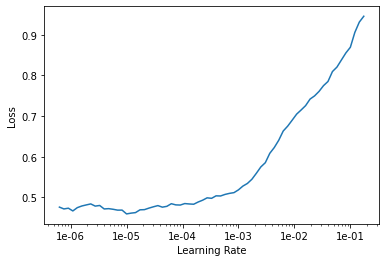

In [32]:
learn_age_multi.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.482818,0.250467,0.891277,02:15
1,0.466311,0.251958,0.890043,02:15
2,0.463552,0.338757,0.891895,02:15
3,0.483340,0.377834,0.891277,02:15
4,0.473713,0.252274,0.890249,02:15
5,0.469382,0.246482,0.889940,02:15
6,0.484132,0.250234,0.894569,02:15
7,0.469796,0.246578,0.892100,02:15
8,0.462166,0.246962,0.892615,02:15
9,0.467954,0.250050,0.892512,02:15


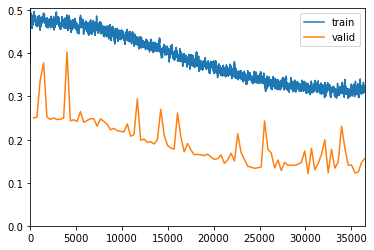

Better model found at epoch 0 with valid_loss value: 0.25046733021736145.
Better model found at epoch 5 with valid_loss value: 0.2464820146560669.
Better model found at epoch 11 with valid_loss value: 0.24368931353092194.
Better model found at epoch 13 with valid_loss value: 0.24191224575042725.
Better model found at epoch 15 with valid_loss value: 0.23991826176643372.
Better model found at epoch 19 with valid_loss value: 0.2311471849679947.
Better model found at epoch 23 with valid_loss value: 0.22266408801078796.
Better model found at epoch 25 with valid_loss value: 0.22043795883655548.
Better model found at epoch 26 with valid_loss value: 0.21914061903953552.
Better model found at epoch 27 with valid_loss value: 0.21767255663871765.
Better model found at epoch 29 with valid_loss value: 0.20771464705467224.
Better model found at epoch 32 with valid_loss value: 0.19836996495723724.
Better model found at epoch 34 with valid_loss value: 0.19352135062217712.
Better model found at epoch 3

In [33]:
learn_age_multi.fit_one_cycle(100, max_lr=slice(1e-6,3e-5), 
                           callbacks=[callbacks.SaveModelCallback(learn_age_multi, 
                                                                  every='improvement', 
                                                                  monitor='valid_loss', 
                                                                  name='stage-2-age_multi')])

In [34]:
learn_age_multi.save('stage-2-rn50-age-multi-utk-final')

## Creating binary dataframes

In [25]:
df_age = get_df_files(concept='age')

In [26]:
df_age

,image_id,age,is_valid
0,UTKFace/58_0_3_20170119211544361.jpg.chip.jpg,1,False
1,UTKFace/38_0_0_20170116224644283.jpg.chip.jpg,1,False
2,UTKFace/18_1_0_20170109214216731.jpg.chip.jpg,0,False
3,UTKFace/32_1_3_20170109142352309.jpg.chip.jpg,1,False
4,UTKFace/26_1_0_20170117153211341.jpg.chip.jpg,0,False
...,...,...,...
9717,crop_part1/2_1_2_20161219161934567.jpg.chip.jpg,0,True
9718,crop_part1/2_1_4_20161221192754807.jpg.chip.jpg,0,True
9719,crop_part1/1_0_2_20161219212824950.jpg.chip.jpg,0,True
9720,crop_part1/38_1_0_20170104200929513.jpg.chip.jpg,1,True


In [27]:
df_train, df_valid = get_df_files(concept='age', df_all_concepts=True)

In [28]:
print(f"train: {len(df_train)}, valid:{len(df_valid)}")

train: 23366, valid:9722


## Creating Dataset, dataloader and databunch

In [29]:
data_age = get_image_databunch(df_age)

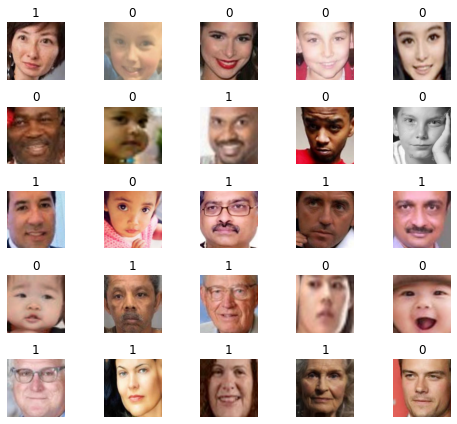

In [30]:
data_age.show_batch(rows=5, figsize=(7,6))

## Create Models

In [31]:
learn_age = cnn_learner(data_age, models.resnet50, metrics=accuracy, callback_fns=ShowGraph)
learn_age.freeze()

In [32]:
learn_age

Learner(data=ImageDataBunch;

Train: LabelList (23366 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,1,0
Path: .;

Valid: LabelList (9722 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,1
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [13]:
learn_age.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


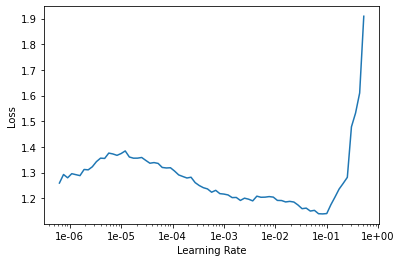

In [14]:
learn_age.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,0.506707,0.258126,0.886649,01:44
1,0.437019,0.235850,0.905472,01:44
2,0.417126,0.243609,0.894672,01:44
3,0.408312,0.270756,0.900021,01:44
4,0.385764,0.206865,0.910512,01:43
5,0.366844,0.203339,0.916375,01:44
6,0.352155,0.178362,0.924090,01:44
7,0.337212,0.208152,0.911335,01:43
8,0.342151,0.170012,0.927587,01:44
9,0.333093,0.175290,0.928410,01:44


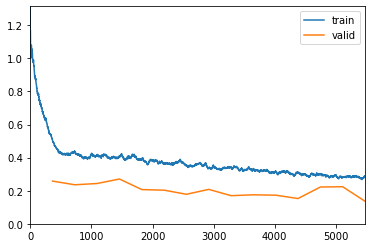

Better model found at epoch 0 with valid_loss value: 0.258125901222229.
Better model found at epoch 1 with valid_loss value: 0.23584963381290436.
Better model found at epoch 4 with valid_loss value: 0.206864595413208.
Better model found at epoch 5 with valid_loss value: 0.20333851873874664.
Better model found at epoch 6 with valid_loss value: 0.1783619225025177.
Better model found at epoch 8 with valid_loss value: 0.17001183331012726.
Better model found at epoch 11 with valid_loss value: 0.1526583582162857.
Better model found at epoch 14 with valid_loss value: 0.13633379340171814.


In [15]:
learn_age.fit_one_cycle(15, max_lr=1e-2, callbacks=[callbacks.SaveModelCallback(learn_age, 
                                                                                  every='improvement', 
                                                                                  monitor='valid_loss', 
                                                                                  name='stage-1-age')])

In [16]:
learn_age.load("stage-1-age")

Learner(data=ImageDataBunch;

Train: LabelList (23366 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
1,1,0,1,0
Path: .;

Valid: LabelList (9722 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,1,1,0,1
Path: .;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), strid

In [17]:
learn_age.unfreeze()

In [18]:
learn_age.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


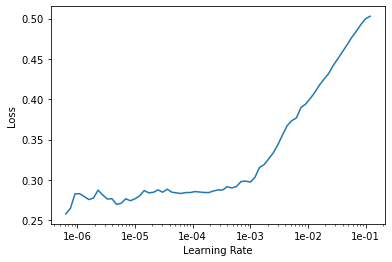

In [19]:
learn_age.recorder.plot()

In [20]:
learn_age.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


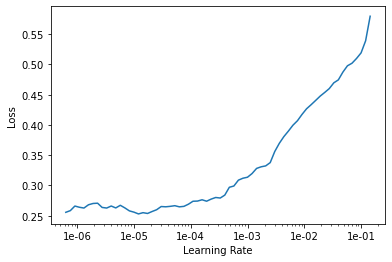

In [21]:
learn_age.recorder.plot()

In [22]:
learn_age.unfreeze()

epoch,train_loss,valid_loss,accuracy,time
0,0.280412,0.132555,0.945896,02:15
1,0.281887,0.134319,0.946410,02:16
2,0.277304,0.133733,0.945896,02:16
3,0.276320,0.160945,0.945896,02:16
4,0.275152,0.134311,0.946410,02:16
5,0.278580,0.147802,0.946204,02:16
6,0.287177,0.190452,0.945690,02:16
7,0.278246,0.135106,0.946719,02:16
8,0.279902,0.302749,0.947027,02:16
9,0.274114,0.172168,0.947336,02:16


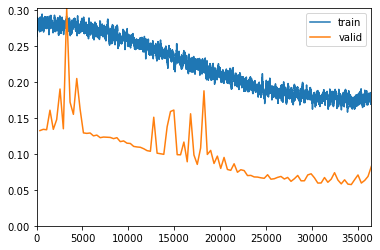

Better model found at epoch 0 with valid_loss value: 0.1325550526380539.
Better model found at epoch 13 with valid_loss value: 0.1293390840291977.
Better model found at epoch 14 with valid_loss value: 0.12868615984916687.
Better model found at epoch 16 with valid_loss value: 0.12520627677440643.
Better model found at epoch 18 with valid_loss value: 0.1227189227938652.
Better model found at epoch 22 with valid_loss value: 0.12134794890880585.
Better model found at epoch 24 with valid_loss value: 0.11719151586294174.
Better model found at epoch 26 with valid_loss value: 0.11505165696144104.
Better model found at epoch 27 with valid_loss value: 0.11462990194559097.
Better model found at epoch 28 with valid_loss value: 0.11054809391498566.
Better model found at epoch 29 with valid_loss value: 0.10978008806705475.
Better model found at epoch 30 with valid_loss value: 0.10931313782930374.
Better model found at epoch 31 with valid_loss value: 0.10731002688407898.
Better model found at epoch 3

In [23]:
learn_age.fit_one_cycle(100, max_lr=slice(1e-6,3e-5), 
                           callbacks=[callbacks.SaveModelCallback(learn_age, 
                                                                  every='improvement', 
                                                                  monitor='valid_loss', 
                                                                  name='stage-2-age')])

In [24]:
learn_age.save('stage-2-rn50-age-utk')

## Calculate accuracy

In [28]:
model_age = get_pytorch_model(weights_dir = 'models', 
                              weights_file = 'stage-2-rn50-age-utk.pth', 
                              is_torch = False, num_classes = 2)

In [13]:
df_train = pd.read_csv('df_train_UTKFace.csv')

In [14]:
df_valid = pd.read_csv('df_valid_UTKFace.csv')

In [10]:
model_age = get_pytorch_model(weights_dir = 'models', weights_file = 'stage-2-rn50-age-utk.pth', 
                                 is_torch = False, num_classes = 2)

In [11]:
model_age.eval()
print(next(model_age.parameters()).is_cuda)

True


In [46]:
train_dl = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_train, 
                    root_dir='', img_pkl_file=None, is_for_train=False)

In [47]:
train_acc = np.round(get_gen_acc(train_dl, model_age, concept_index=0)/len(df_train)*100, 2)

In [48]:
print(f"accuracy of age model on train data: {train_acc}%")

accuracy of age model on train data: 93.44%


In [43]:
valid_dl = get_dataloader(kwargs_func=kwargs, batch_size=20, pd_advx=df_valid, 
                    root_dir='', img_pkl_file=None, is_for_train=False)

In [44]:
valid_acc = np.round(get_gen_acc(valid_dl, model_age, concept_index=0)/len(df_valid)*100, 2)

In [45]:
print(f"accuracy of age model on validation data: {valid_acc}%")

accuracy of age model on validation data: 97.03%


In [15]:
df_valid_0 = df_valid.loc[df_valid['age'].isin([0])]

valid_dl_0 = get_dataloader(kwargs_func=kwargs, batch_size=20, 
                            pd_advx=df_valid_0, root_dir='', 
                            img_pkl_file=None, is_for_train=False)

valid_acc_0 = np.round(get_gen_acc(valid_dl_0, model_age, 
                                   concept_index=0)/len(df_valid_0)*100, 2)

In [16]:
print(f"accuracy of age model on validation data for ages <= 30: {valid_acc_0}%")

accuracy of age model on validation data for ages <= 30: 98.47%


In [17]:
df_valid_1 = df_valid.loc[df_valid['age'].isin([1])]

valid_dl_1 = get_dataloader(kwargs_func=kwargs, batch_size=20, 
                            pd_advx=df_valid_1, root_dir='', 
                            img_pkl_file=None, is_for_train=False)

valid_acc_1 = np.round(get_gen_acc(valid_dl_1, model_age, 
                                   concept_index=0)/len(df_valid_1)*100, 2)

In [18]:
print(f"accuracy of gender model on validation data for male gender: {valid_acc_0}%")

accuracy of gender model on validation data for male gender: 98.47%
